Generate FEM solution for 2D Poisson problem

* For type 1 problem, we apply both Dirichlet and Neumann boundary conditions

In [1]:
import meshio
import numpy as np
import matplotlib.pyplot as plt
import gaussian_random_fields as gr
import random
import h5py

In [2]:
class MeshSquareFEM():
    """ Handle a simple square mesh with quad elements
    0: background square
    
    Parameters:
        size: length of the square plate
        nnode_edge: number of nodes along edges of the plate
    """

    def __init__(self, size, nnode_edge, outfile = None):
        self.size = size
        self.nnode_edge = nnode_edge
        self.node_list = np.arange(nnode_edge*nnode_edge)
        self.mesh = None
        self.mesh = self.generate_mesh()
        self.generate_node_index()
        
        if outfile is not None:
            self.save_mesh(outfile)

    def generate_mesh(self):
        x = np.linspace(0,self.size,self.nnode_edge, dtype=np.float32)
        y = np.linspace(0,self.size,self.nnode_edge, dtype=np.float32)
        ms_x, ms_y = np.meshgrid(x,y)
        x = np.ravel(ms_x).reshape(-1,1)
        y = np.ravel(ms_y).reshape(-1,1)
        z = np.zeros_like(x, dtype=np.float32)
        points = np.concatenate((x,y,z),axis=1)
        n_element = (self.nnode_edge-1)*(self.nnode_edge-1)
        nodes = np.linspace(0,points.shape[0],points.shape[0],endpoint=False,dtype=int).reshape(self.nnode_edge,self.nnode_edge)
        cells = np.zeros((n_element,4),dtype=int)
        cells[:,0] = np.ravel(nodes[:self.nnode_edge-1,:self.nnode_edge-1])
        cells[:,1] = np.ravel(nodes[:self.nnode_edge-1,1:])
        cells[:,2] = np.ravel(nodes[1:,1:])
        cells[:,3] = np.ravel(nodes[1:,:self.nnode_edge-1])
        return meshio.Mesh(points, [("quad",cells)])

    def generate_node_index(self):
        '''Generate node index matrix that indicate boundary (True) or internal nodes (False)'''
        boundary = []
        top = []
        bottom = []
        left = []
        right = []
        
        for pt in self.mesh.points:
            temp_bool = [False, False, False, False, False] # Top, Bottom, Left, Right, Boundary
            if (np.isclose(pt[0],0)):
                temp_bool[2], temp_bool[4] = True, True # left
            if (np.isclose(pt[0],self.size)):
                temp_bool[3], temp_bool[4] = True, True # right
            if (np.isclose(pt[1],self.size)):
                temp_bool[0], temp_bool[4] = True, True # top
            if (np.isclose(pt[1],0)):
                temp_bool[1], temp_bool[4] = True, True # bottom
            
            top.append(temp_bool[0])
            bottom.append(temp_bool[1])
            left.append(temp_bool[2])
            right.append(temp_bool[3])
            boundary.append(temp_bool[4])

        # assign top/right/bottom boundaries as Dirichlet bc -> temperature fix
        dirich = np.any([top, right, bottom], axis=0)
        self.bcnode_essential = self.node_list[dirich] 

        # assign left boundary as Neumann bc -> heat flux
        neumann = np.any([left], axis=0)
        self.bcnode_natural = self.node_list[neumann]
        
        self.node_top = self.node_list[top]
        self.node_bottom = self.node_list[bottom]
        self.node_left = self.node_list[left]
        self.node_right = self.node_list[right]
        self.node_ndirich = self.node_list[np.invert(dirich)] # nodes that no dirichlet bc
    
    def shapefunc(self, p):
        # shape function
        N = 0.25*np.array([[(1-p[0])*(1-p[1])],
                           [(1+p[0])*(1-p[1])],
                           [(1+p[0])*(1+p[1])],
                           [(1-p[0])*(1+p[1])]])

        dNdp = 0.25*np.array([[-(1-p[1]), -(1-p[0])],
                              [(1-p[1]), -(1+p[0])],
                              [(1+p[1]), (1+p[0])],
                              [-(1+p[1]), (1-p[0])]])
        return N, dNdp

    def save_mesh(self,outfile = 'mesh_square.vtk'):
        self.mesh.write(outfile)

In [3]:
class GridFEM():
    '''
    Note: the n should be the number of elements along edges, e.g., 
    there are (n-1)*(n-1) internal grid points 
    '''
    def __init__(self, n_elem, size = 2):
        self.size = size
        self.n = n_elem 
        self.omega = 2/3
        self.qpts = np.array([[-1, 1, 1, -1], [-1, -1, 1, 1]])/np.sqrt(3) #[2x4]
        self.d = np.zeros((n_elem+1)*(n_elem+1))
        self.grid = MeshSquareFEM(size, nnode_edge=n_elem+1)
        
    def CreateA(self):
        '''
        Stiffness matrix, return A_F and A_EF 
        ''' 
        A = np.zeros(((self.n+1)*(self.n+1),(self.n+1)*(self.n+1)))
        for i, c in enumerate(self.grid.mesh.cells_dict['quad']):
            xe = self.grid.mesh.points[c,:].T[:2,:] #[2x4]
            alpha = self.grid.mesh.cell_data['alpha'][i]
            D = alpha*np.eye(2)
            Ke = np.zeros((4,4))
            for q in self.qpts.T:
                [_,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                dNdx = np.dot(dNdp, np.linalg.inv(J)) #[4x2]
                B = np.zeros((2,4))
                B[0,:] = dNdx[:,0]
                B[1,:] = dNdx[:,1]
                Ke += np.linalg.det(J)*np.dot(B.T,np.dot(D,B))
            A[np.ix_(c,c)] += Ke
            
        return A[np.ix_(self.grid.node_ndirich,self.grid.node_ndirich)], A[np.ix_(self.grid.bcnode_essential,self.grid.node_ndirich)]

    def UpdateSource(self, f = None):
        '''
        Return the rhs internal sourcing term with modification from finite element term
        '''
        ff = np.zeros_like(f)
        for c in self.grid.mesh.cells_dict['quad']:
            xe = self.grid.mesh.points[c,:].T[:2,:] #[2x4]
            fe = np.zeros(4)
            for q in self.qpts.T:
                [N,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                temp = np.linalg.det(J)*np.dot(N,np.dot(N.T,f[c])) #[4x1]
                fe += temp
            ff[c] += fe
        return ff
    
    def NeumannBC(self, f, bc_field):
        connection = np.stack((self.grid.bcnode_natural[:-1],self.grid.bcnode_natural[1:]), axis=-1)
        for c in connection:
            xe = self.grid.mesh.points[c,:][:,:2] #[2x2]
            le = np.linalg.norm(xe[1,:]-xe[0,:])
            for q in [1./np.sqrt(3), -1./np.sqrt(3)]:
                N = 0.5*np.array([1-q, 1+q])
                f[c] += np.dot(N,np.dot(N.T,bc_field[c]))*le/2 #[2x1]
        return f[self.grid.node_ndirich]

    def DirichBC(self, bc_value = None):
        '''Boundary values order: top, right, bottom'''
        if (bc_value is None):
            bc_value = np.random.rand(3)
        
        self.d[self.grid.node_top] = bc_value[0]
        self.d[self.grid.node_bottom] = bc_value[1]
        #self.d[self.grid.node_left] = bc_value[2]
        self.d[self.grid.node_right] = bc_value[3]
        return self.d[self.grid.bcnode_essential]

    def GaussianRF(self, n, a_interval):
        alpha = random.uniform(2,5)
        a0, a1 = a_interval[0],a_interval[1]
        field = gr.gaussian_random_field(alpha=alpha, size=n, flag_normalize=False)
        f_min, f_max = np.min(field), np.max(field)
        rf = (a1-a0)*(field-f_min)/(f_max-f_min)+a0
        return rf

    def Solve(self, material, dirich_bc, neumann_bc_field, f):
        '''
        Solve the linear equation system
        neumann_bc_field: shape is [(n+1) x (n+1)]
        '''
        # create cell data
        self.grid.mesh.cell_data['alpha'] = material[:, :, 0].reshape(self.n*self.n)

        d_E = self.DirichBC(dirich_bc)
        f_source = self.UpdateSource(f)
        f_F = self.NeumannBC(f_source, neumann_bc_field)
        self.A, self.A_EF = self.CreateA()
        b = f_F - np.dot(self.A_EF.T, d_E)
        d_F = np.linalg.solve(self.A, b)
        self.d[self.grid.node_ndirich] = d_F

    def PlotField(self, field = None):
        '''Default is to plot the solution field'''
        if(field is None):
            field = self.d
        
        field2d = field.reshape((self.n+1, self.n+1))
        im = plt.imshow(field2d, origin='lower')
        
        plt.axis('off')
        plt.colorbar(im)
        plt.show()

In [4]:
def loading_type1(n, d_values, n_values):
    '''Loading: fix top/right/bottom boundary as Dirichlet bc.; left as Neumann bc.'''
    # dirichlet geometry, 1.0 inner points; 0.0 elsewhre
    dirich_idx = np.ones((n, n))
    dirich_idx[-1, :] = 0. # top, bottom, left, right
    dirich_idx[0, :] = 0.
    #dirich_idx[:, 0] = 0.
    dirich_idx[:, -1] = 0.

    dirich_value = np.zeros_like(dirich_idx)
    dirich_value[-1, :] = d_values[0] # top, bottom, left, right
    dirich_value[0, :] = d_values[1]
    #dirich_value[:, 0] = d_values[2]
    dirich_value[:, -1] = d_values[3]

    # define Neumann boundary, 1.0 traction boundary; 0 else
    neumann_idx = np.zeros((n, n))
    #neumann_idx[-1, :] = 1 # top, bottom, left, right
    #neumann_idx[0, :] = 1
    neumann_idx[:, 0] = 1
    #neumann_idx[:, -1] = 1

    neumann_value = np.zeros_like(neumann_idx)
    #neumann_value[-1, :] = n_values[0] # top, bottom, left, right
    #neumann_value[0, :] = n_values[2]
    neumann_value[:, 0] = n_values[2]
    #neumann_value[:, -1] = n_values[1]

    return dirich_idx, dirich_value, neumann_idx, neumann_value

In [5]:
n = 2**5
prob = GridFEM(n)

In [6]:
#f = prob.GaussianRF(n+1, [0,10]).reshape(((n+1)*(n+1),))
f = np.zeros((n+1)*(n+1))
material = np.ones((n, n, 1)) 
dirich_bc = [0, 2, None, 1] # top, bottom, left, right
neumann_bc = [None, None, 3, None] 
dirich_idx, dirich_value, neumann_idx, neumann_value = loading_type1(n+1, dirich_bc, neumann_bc)

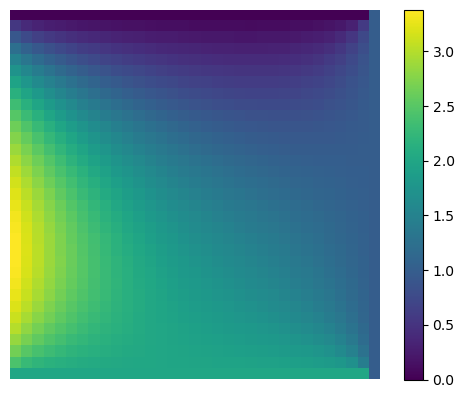

In [7]:
prob.Solve(material, dirich_bc, neumann_value.reshape(((n+1)*(n+1),)), f = f)
prob.PlotField()

In [8]:
# Create dataset
n_data = 1
datafile = "thermal_test.h5"

dataset = {}
dirich_idx_data = np.zeros((n_data, n+1, n+1, 1))
dirich_value_data = np.zeros((n_data, n+1, n+1, 1))
neumann_idx_data = np.zeros((n_data, n+1, n+1, 1))
neumann_value_data = np.zeros((n_data, n+1, n+1, 1))
mask_data = np.zeros((n_data, n+1, n+1, 1))
material_data = np.zeros((n_data, n, n, 1))
f_data = np.zeros((n_data, n+1, n+1))
u_data = np.zeros((n_data, n+1, n+1))
for i in range(n_data):
    #f = prob.GaussianRF(n+1, [-5,5]).reshape(((n+1)*(n+1),))
    f = np.zeros(((n+1)*(n+1),))
    dirich_bc = [0, 2, None, 1]
    neumann_bc = [None, None, 3, None]
    dirich_idx, dirich_value, neumann_idx, neumann_value = loading_type1(n+1, dirich_bc, neumann_bc)
    #material = prob.GaussianRF(n, [0.5,2]).reshape(n,n,1)
    material = np.ones((n,n,1))
    prob.Solve(material, dirich_bc, neumann_value.reshape(((n+1)*(n+1),)), f = f)
    mask_data[i,:,:,0] = np.ones((n+1,n+1))
    material_data[i] = material
    dirich_idx_data[i,:,:,0] = dirich_idx
    dirich_value_data[i,:,:,0] = dirich_value
    neumann_idx_data[i,:,:,0] = neumann_idx
    neumann_value_data[i,:,:,0] = neumann_value
    f_data[i,:,:] = f.reshape((n+1, n+1))
    u_data[i,:,:] = prob.d.reshape((n+1, n+1))
    print("Problem #-"+str(i)+" solved")

Problem #-0 solved


In [9]:
dataset['mask'] = mask_data
dataset['dirich_idx'] = dirich_idx_data
dataset['dirich_value'] = dirich_value_data
dataset['neumann_idx'] = neumann_idx_data
dataset['neumann_value'] = neumann_value_data
dataset['material'] = material_data
dataset['source'] = f_data
dataset['solution'] = u_data

with h5py.File(datafile, "w") as hf:
    for key, item in dataset.items():
        hf[key] = item